In [1]:
%reset
import gcm_filters
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cmocean
from xgcm import Grid
print('done')

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


done


In [69]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
print(os)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
<xarray.Dataset>
Dimensions:        (Interface: 16, Layer: 15, Time: 7286)
Coordinates:
  * Layer          (Layer) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * Interface      (Interface) float64 1.022e+03 1.023e+03 ... 1.028e+03
  * Time           (Time) float64 0.0 5.0 10.0 ... 3.249e+04 3.25e+04 3.25e+04
Data variables:
    Ntrunc         (Time) float64 ...
    En             (Time) float64 ...
    APE            (Time, Interface) float64 ...
    KE             (Time, Layer) float64 ...
    H0             (Time, Interface) float64 ...
    Mass_lay       (Time, Layer) float64 ...
    Mass           (Time) float64 ...
    Mass_chg       (Time) float64 ...
    Mass_anom      (Time) float64 ...
    max_CFL_trans  (Time) float64 ...
    max_CFL_lin    (Time) float64 ...
Attributes:
    filename:  ./ocean.stats.nc


In [70]:
print(av)

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    

In [71]:
lat=  np.array(av.yh)     #np.array(fs['geolon']); 
lon=  np.array(av.xh)     #fs['geolat']
area= np.array(fs['area_t'])
H = av.h.sum('zl').mean('time')
SSH = av.h.sum('zl')-H
SSH = np.array(SSH[-1,:,:])

In [72]:
area.shape

(560, 240)

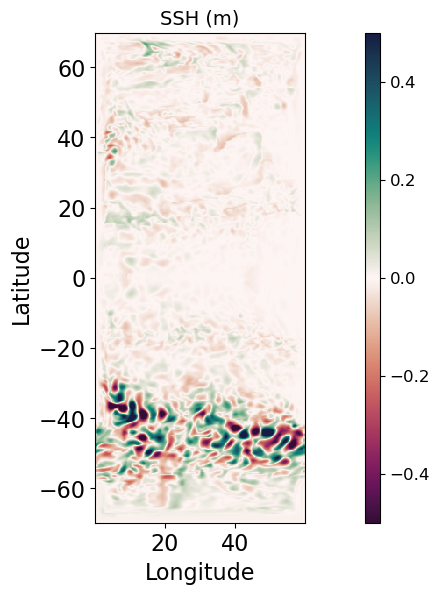

In [73]:
#Plotting KE for whole domain (FILTERED KE)
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('SSH (m)',fontsize=14)


plotted =ax1.pcolor(lon,lat,SSH,cmap=cmocean.cm.curl_r,vmin=-.5,vmax=.5)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

In [74]:
from scipy.io import savemat
data_vars = {"lon": lon, "lat": lat, "SSH": SSH, "area":area}
savemat("SSH_025.mat", data_vars)

In [75]:
print('all done')

all done


In [76]:
%pwd

'/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis'